[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/nmfs-opensci/EDMW-EarthData-Workshop-2025/blob/main/tutorials/clean/Tutorial_2_Rrs_AVW.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link] [![JupyterHub](https://img.shields.io/badge/Workshop_Hub-green?style=for-the-badge)][jupyter-link]

[download-link]: https://github.com/nmfs-opensci/EDMW-EarthData-Workshop-2025/blob/main/tutorials/clean/Tutorial_2_Rrs_AVW.ipynb
[colab-link]: https://colab.research.google.com/github/nmfs-opensci/EDMW-EarthData-Workshop-2025/blob/main/tutorials/clean/Tutorial_2_Rrs_AVW.ipynb
[jupyter-link]: https://workshop.nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/nmfs-opensci/EDMW-EarthData-Workshop-2025/main/tutorials/clean/Tutorial_2_Rrs_AVW.ipynb

It can be a little tricky working with a netcdf that is (...checks notes) **172** layers thick. Each individual layer in the PACE_OCI*_*AOP* files represents a 
1272 x 1709 array of remote sensing reflectance values. This is a lot of information to take in, so how can we better conceptualize this information?

*Cue up triumphant brass horn noises*

Enter the realm of the **Apparent Visible Wavelength (or AVW)**. Let's not go into too much detail here so that we can get to work, but in short, the AVW represents a one-dimensional variable that describes the weighted harmonic mean of a given Rrs spectrum. Imagine trying to balance a single Rrs spectrum on the tip of a pin - the wavelength where the spectrum is perfectly balanced is the AVW (units of nm). This balance point shifts proportionally in response to subtle changes in that spectrum. As a typical rule of thumb, lower AVW values (440 - 490 nm) represent relatively clear, less productive waters while higher AVW values (490 - 600 nm) represent more turbid, productive water masses. 

Let's dive in and mess around with some spectra and see what these images are trying to tell us. By the end of this tutorial, you will have:

>📘 Learning Objectives
>
> 1. Create a pretty map of the Apparent Visible Wavelength (AVW) product
> 2. Draw a customized transect on that image and extract a "slice" of data
> 3. Plot Rrs spectra along that transect as a function of AVW values
> 4. Extract a user-defined 5x5 box from the image and plot the mean Rrs with standard deviation


## Get the data from NASA Earthdata

Login to NASA Earthdata

In [2]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

These "Level 2" files have many smaller spatial panels or scenes to cover the whole globe. Specifying a bounding box will help narrow down the results. Here, I'm looking for data off the coast of Louisiana, on March 5, 2025.

In [3]:
bbox = (-98.0, 27.0, -96.0, 31.0)
import xarray as xr
results = earthaccess.search_data(
    short_name = "PACE_OCI_L2_AOP",
    temporal = ("2025-03-05", "2025-03-05"),
    bounding_box = bbox
)
# Create a fileset
fileset = earthaccess.open(results);

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Level 2 netcdf files have "groups". The next code helps you identify the various "groups" within the file so you know where to pull data from. Once you know the groups, it will be the same across all the Level 2 PACE files. 

In [4]:
import h5netcdf
with h5netcdf.File(fileset[0]) as file:
    groups = list(file)
groups

['sensor_band_parameters',
 'scan_line_attributes',
 'geophysical_data',
 'navigation_data',
 'processing_control']

## Let's load the Rrs and AVW data

Let's load up our libraries, and then extract the relevant data we need. 

In [6]:
# ---- Load Libraries ----
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from scipy.integrate import trapezoid

In [7]:
# Load relevant datasets
ds = xr.open_dataset(fileset[0], group="geophysical_data")
ds_nav = xr.open_dataset(fileset[0], group="navigation_data").set_coords(("latitude", "longitude"))
ds_wave = xr.open_dataset(fileset[0], group="sensor_band_parameters").set_coords(("wavelength_3d",))

# Merge data for convenience. Create rrs and avw only variables
ds_merged = xr.merge((ds, ds_nav, ds_wave))
rrs = ds_merged["Rrs"]
avw = ds_merged["avw"]
wavelengths = rrs["wavelength_3d"]

## Mapping time!

Let's make a map of the AVW product to get a sense of what kind of water masses we're dealing with here and explore what looks interesting. 

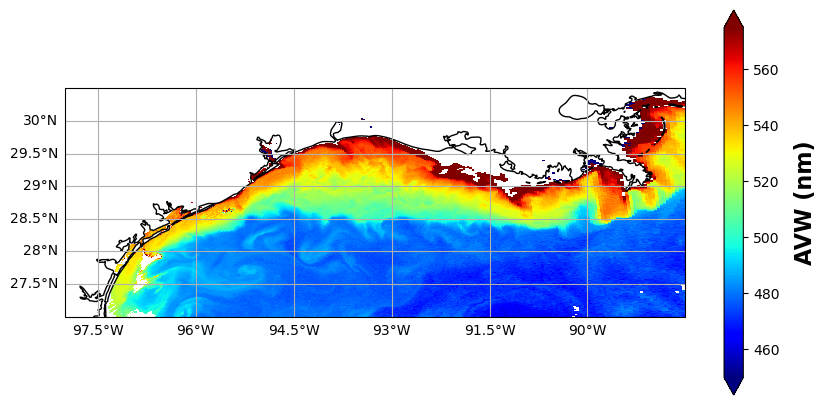

In [8]:
# ---- Make product plot ----
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.gridlines(draw_labels={"bottom": "x", "left": "y"})
ax.coastlines()

# ---- Adjust colorbar limits and tell xarray to use your ax ----
plot = avw.plot(
    x="longitude", y="latitude",
    cmap="jet", vmin=450, vmax=575,
    ax=ax  
)

# ---- Crop the image to preferred location ----
ax.set_xlim(-98.0, -88.5)
ax.set_ylim(27.0, 30.5)

# ---- Customize colorbar label ----
plot.colorbar.set_label("AVW (nm)", labelpad=10, fontsize=16, fontweight="bold")


Pretty, right? This is a very optically diverse scene. Hidden in the Rrs data are various indicators that help determine if we're looking at re-suspended seafloor sediments, phytoplankton blooms, dissolved organic matter, detrital materials, Loop current waters, or maybe even all of the above! Alright, let's go ahead and dive in and see what is going on beneath the AVW "hood".

## Let's extract some data

Take a look at the map, and think of a starting and ending point. We're going to **build a transect** and extract the underlying data. I pre-filled some values, but feel free to put in your own start/end coordinates below, using the map grid as a reference. Keep in mind, we're in the Western Hemisphere here, so the longitudes are negative (-) values, e.g., 93°W = -93.0. Latitude is looking at the bright side of life and staying positive (for this scene anyway). The code below adds the transect line to the plot we made in the previous cell. 

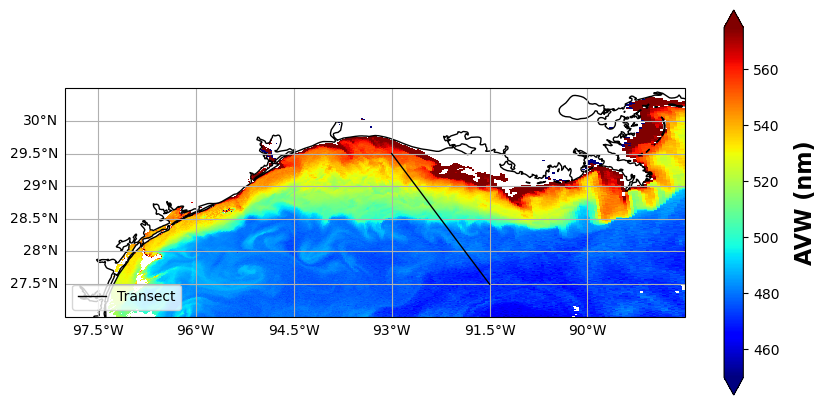

In [9]:
# ---- User Input: Define Transect ----
lat1, lon1 = 29.5, -93.0
lat2, lon2 = 27.5, -91.5
npts = 100
lats = np.linspace(lat1, lat2, npts)
lons = np.linspace(lon1, lon2, npts)

# ---- Add transect to the existing plot above ----
ax = plot.axes  # plot is defined in the previous cell
ax.plot(lons, lats, color="black", linewidth=1, transform=ccrs.PlateCarree(), label="Transect")
ax.legend(loc="lower left")

fig = ax.get_figure()
fig

## Let's see what that extracted data looks like

Next, for every data point that was extracted along the transect, we're going to pull together 172 layers of Rrs information and see what each of those spectra look like. But wait, there's more! To help add some context to those spectra, we're going to make sure that we color code each spectra so that it corresponds to the colormap on our AVW image. In other words, a red-colored spectrum will represent data that you pulled from a red part of the map. 

> [!NOTE]
> Getting the nearest lat/lon points from Level 2 data.
>
> Level 2 data is not on a regular grid, so using `sel(..., method="nearest")` like you can with data on a regular 2D grid will not work. Instead, we have to compute all the 2D distances and find the minimum. That is what the `dist =` line of code is doing below.

This will generate two plots. The first plot will show the Rrs spectrum "as is" in units of inverse steradians (sr^-1). It is useful to examine this, because it tells you something about the *brightness* of the water. Sometimes, two spectral shapes may look very similar, but the relative magnitude of values can help you determine if you're looking at a more highly scattering water mass (higher relative magnitude) versus a highly absorbing water mass (lower relative magnitude). In the second plot, we divided the Rrs by the integrated area under the spectrum. This puts everything "equal" in terms of brightness, allowing you to focus more on absolute spectral shape differences. Both are informative in their own way.

Feel free to go back and build a new transect, explore, and get a feel for what different water masses look like.

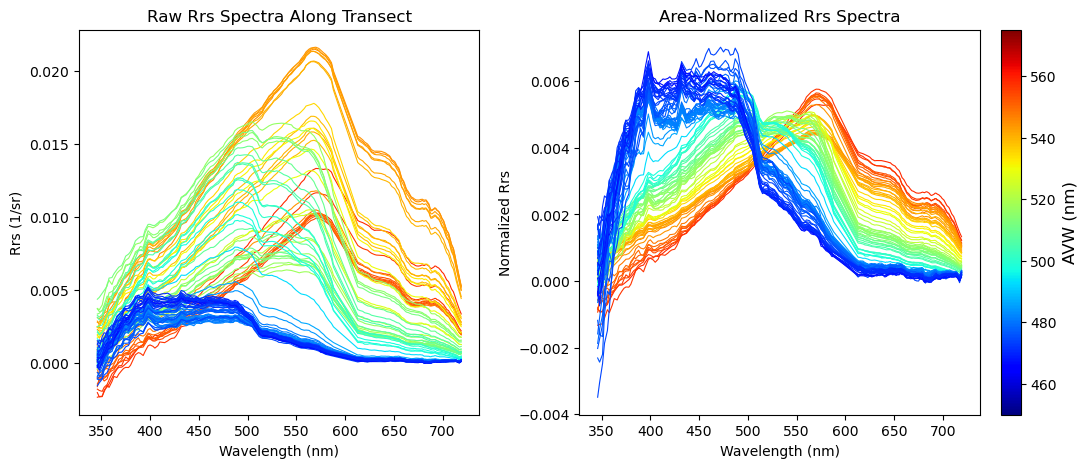

In [10]:
# ---- Color setup ----
cmap = plt.get_cmap("jet")
norm = colors.Normalize(vmin=450, vmax=575)

# Prepare figure
fig, (ax_raw, ax_norm) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={"wspace": 0.25})

# ---- For setting y-limits of normalized plot ----
ymin, ymax = np.inf, -np.inf

# ---- Plot spectra ----
for lat, lon in zip(lats, lons):
    # Get nearest index from 2D coordinate arrays
    lat_vals = rrs.latitude.values
    lon_vals = rrs.longitude.values
    dist = np.sqrt((lat_vals - lat)**2 + (lon_vals - lon)**2)
    i, j = np.unravel_index(np.argmin(dist), dist.shape)

    # Proceed with extraction
    spectrum = rrs.isel(number_of_lines=i, pixels_per_line=j).values
    avw_val  = avw.isel(number_of_lines=i, pixels_per_line=j).values

    # Normalize spectrum
    area = trapezoid(spectrum, wavelengths)
    spec_norm = spectrum / area if area > 0 else spectrum

    # Update y-limits for normalized spectra
    ymin = min(ymin, np.nanmin(spec_norm))
    ymax = max(ymax, np.nanmax(spec_norm))

    # Plot
    color = cmap(norm(avw_val))
    ax_raw.plot(wavelengths, spectrum, color=color, linewidth=0.8)
    ax_norm.plot(wavelengths, spec_norm, color=color, linewidth=0.8)

# ---- Shared colorbar ----
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=(ax_raw, ax_norm), location='right', pad=0.02)
cbar.set_label("AVW (nm)", fontsize=12)

# ---- Titles and labels ----
ax_raw.set_title("Raw Rrs Spectra Along Transect")
ax_norm.set_title("Area-Normalized Rrs Spectra")
ax_raw.set_xlabel("Wavelength (nm)")
ax_raw.set_ylabel("Rrs (1/sr)")
ax_norm.set_xlabel("Wavelength (nm)")
ax_norm.set_ylabel("Normalized Rrs")
ax_norm.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax - ymin))

plt.show()

As you can likely see from your plots above, the optical properties of the ocean can be quite variable. So much so, in fact, that if we're looking to extract values from the satellite image for more quantitative analyses (e.g., matching up to a ship or animal observation), you're going to want a little context of the relative variability surrounding that pixel to account for spatial uncertainty. 

## Let's make a match :-)

As our last exercise in this tutorial, we're going to define a single location in the image, and then extract a 5x5 box of pixels around that central location. With this information, we will plot the mean + standard deviation of the spectra in that 5x5 box. This is a common way scientists extract data for satellite calibration, validation, and algorithm development. Let's start by picking a point in the image.

In [11]:
target_lat = 29.0
target_lon = -93.0

Using that, we'll find the closest central point by subtracting your lat/lon input from all lat/lon values in the array. Take the absolute value of that, and the lowest number will yield your closest pixel matchup. We'll make a mini box that goes +2 pixels out in every direction, which translates to a 5x5 pixel cube that we can run our statistics on.  

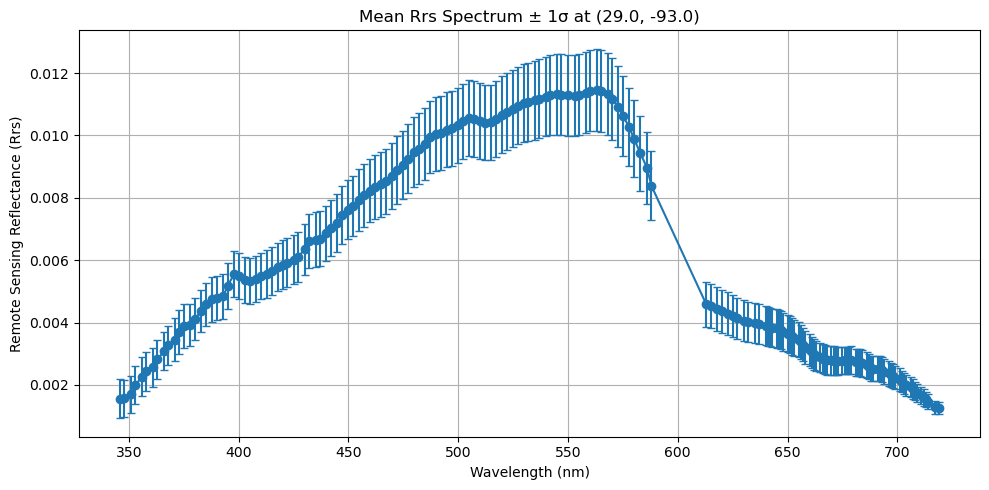

In [12]:
# Find nearest pixel
lat_vals = rrs.latitude.values
lon_vals = rrs.longitude.values
dist = np.abs(lat_vals - target_lat) + np.abs(lon_vals - target_lon)
i, j = np.unravel_index(dist.argmin(), lat_vals.shape)

# Define 5x5 box bounds
half_box = 2  # for a 5x5 box
i_min = max(i - half_box, 0)
i_max = min(i + half_box + 1, lat_vals.shape[0])
j_min = max(j - half_box, 0)
j_max = min(j + half_box + 1, lat_vals.shape[1])

# Extract and compute statistics
rrs_box = rrs.isel(number_of_lines=slice(i_min, i_max), pixels_per_line=slice(j_min, j_max))
rrs_mean = rrs_box.mean(dim=("number_of_lines", "pixels_per_line"))
rrs_std = rrs_box.std(dim=("number_of_lines", "pixels_per_line"))

# Plot mean spectrum with standard deviation
plt.figure(figsize=(10, 5))
plt.errorbar(wavelengths, rrs_mean, yerr=rrs_std, fmt='-o', capsize=3)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Remote Sensing Reflectance (Rrs)")
plt.title(f"Mean Rrs Spectrum ± 1σ at ({target_lat}, {target_lon})")
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary

Well folks, there you have it. Hyperspectral data, demystified. Well, maybe not entirely, but the tools here can be adapted to really help you explore the data and get a little more hands on with the raw reflectance information. Users often shy away from this information in favor of more geophysical variables that can be modeled and explained in the context of an ecosystem, like chlorophyll-a. This is completely understandable, but do keep in mind that every step you get away from the reflectance introduces additional uncertainties. Some folks have found that using raw reflectance values can outperform the use of more derived products, as in the case of [modeling Atlantic Sturgeon habitat](https://doi.org/10.1093/icesjms/fsx187). 